In [1]:
import time
import math
import itertools
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['mathtext.fontset'] = 'stix'

import hoomd
import gsd.hoomd

from pair import lj

from order_parameters import compute_num_liq as compute_op
from metad import WTmetadUpdater

In [2]:
seed=9920
device = hoomd.device.CPU()
sim = hoomd.Simulation(device=device, seed=seed) # 5th one can be redo because it's done with seed 5.
mc = hoomd.hpmc.integrate.Sphere(default_d=0.1)
mc.shape["A"] = dict(diameter=1.0)

sigma = 1.0
epsilon = 1.88

lj = lj.format(sigma=sigma, epsilon=epsilon)
patch = hoomd.hpmc.pair.user.CPPPotential(r_cut=3.0*sigma,
                                          code=lj,
                                          param_array=[])

mc.pair_potential = patch
sim.create_state_from_gsd(filename='./DATA/random.gsd')

In [3]:
trial=seed
rng = np.random.default_rng(trial) # random generator
wtmetadupdater = hoomd.update.CustomUpdater(action=WTmetadUpdater(rng=rng,
                                                                  h0=0.5,
                                                                  sigma=2.0,
                                                                  T=1,
                                                                  dT=7,
                                                                  stride=50), trigger=1)
wtmetadupdater.set_init_snapshot(sim.state.get_snapshot())

In [4]:
logger = hoomd.logging.Logger()
logger.add(mc, quantities=['type_shapes'])
logger.add(wtmetadupdater, quantities=['op', 
                                       'vbias', 
                                       'ebetac'])

trigger = hoomd.trigger.And([hoomd.trigger.Periodic(100),
                             hoomd.trigger.After(sim.timestep+5000)])
gsd_writer = hoomd.write.GSD(filename='./DATA/metad.gsd',
                             trigger=trigger,
                             mode='wb',
                             filter=hoomd.filter.All(),
                             log=logger)

/Users/lina492375qw1188/opt/miniconda3/envs/patchy/lib/python3.9/site-packages/hoomd/write/gsd.py:183: FutureWarning: log keyword arguments passed to <hoomd.write.gsd.GSD object at 0x12f95be20> is deprecated since v3.9.0. Use logger instead.
  warnings.warn(


In [5]:
tune = hoomd.hpmc.tune.MoveSize.scale_solver(moves=['a', 'd'],
                                             target=0.2,
                                             trigger=hoomd.trigger.And([hoomd.trigger.Periodic(100),
                                                                        hoomd.trigger.Before(sim.timestep+5000)]),
                                             max_translation_move=0.2,
                                             max_rotation_move=0.2)

In [6]:
sim.operations.writers.append(gsd_writer)
sim.operations.integrator = mc
sim.operations.updaters.append(wtmetadupdater)
sim.operations.tuners.append(tune)

#### tune

In [7]:
sim.run(5000)

#### equilibriate

In [8]:
start = time.time()

sim.run(1e4)

print('Time elapsed', time.time()-start)

Time elapsed 32.04951882362366


In [9]:
traj = gsd.hoomd.open('./DATA/metad.gsd', 'rb')

op_arr = []
vbias_arr = []
ebetac_arr = []
for frame in traj:
    op_arr.append(frame.log['metad/WTmetadUpdater/op'][0])
    vbias_arr.append(frame.log['metad/WTmetadUpdater/vbias'][0])
    ebetac_arr.append(frame.log['metad/WTmetadUpdater/ebetac'][0])

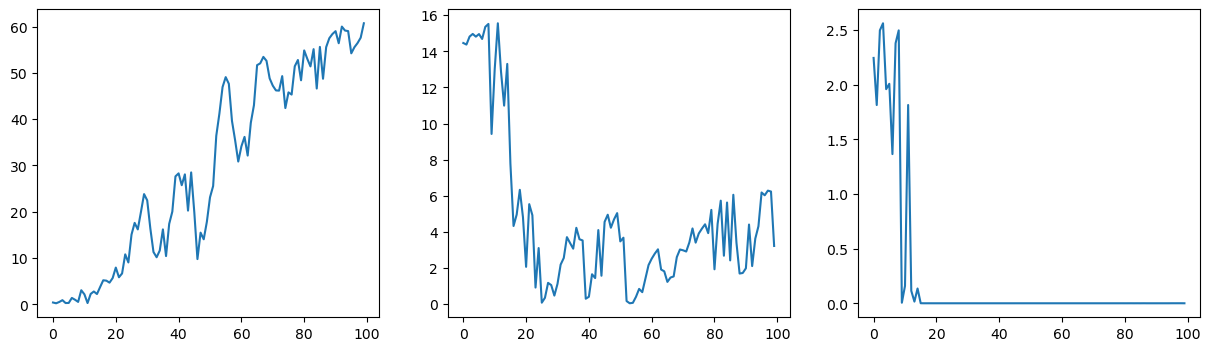

In [10]:
vbias_arr = np.array(vbias_arr)
weight_arr = np.exp(vbias_arr)/ebetac_arr

fig = plt.figure(figsize=(15,4))

ax = fig.subplots(nrows=1, ncols=3)

ax[0].plot(op_arr)
ax[1].plot(vbias_arr)
ax[2].plot(weight_arr)

plt.show()